In [1]:
from __future__ import annotations

#os packages
import os
import itertools
import glob
import tempfile
import time
from pathlib import Path

#Data Packages
import numpy as np
import dask.array as da
import xarray as xr

#xarray parellel
from distributed import Client
Client()

import xclim as xc
xr.set_options(display_style="html")

import pandas as pd

#Stats Packages

#Plotting Packages
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.offsetbox import AnchoredText
from matplotlib import gridspec, colors, colormaps, cm, ticker

# deprecated   import lcc_plotting_functs as lcc_pf     #.py file containing plotting functions for LCC gridline ticks

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
import cartopy.io.img_tiles as cimgt

from datetime import datetime, timedelta

#MPL inline magic
%matplotlib inline

# Output folder
output_folder = Path(tempfile.mkdtemp())

2023-08-25 20:54:54,648 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-046vpq6x', purging
2023-08-25 20:54:54,648 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-k419ni3x', purging
2023-08-25 20:54:54,649 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-g6pxapre', purging
2023-08-25 20:54:54,649 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-710mkd55', purging
2023-08-25 20:54:54,649 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-iet1v5wx', purging
2023-08-25 20:54:54,650 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-vwzav63o', purging
/anaconda3/envs/pyEAE/lib/python3.9/site-packages/xclim/indices/fire/_cffwis.py:217: NumbaDeprecationWarning: The 'nopython' keyword argument 

In [2]:
#set up a dask env. 
from distributed import Client

# Depending on your workstation specifications, you may need to adjust these values.
# On a single machine, n_workers=1 is usually better.
client = Client(n_workers=8, threads_per_worker=4, memory_limit="64GB") #mem limit * n_workers = total memory allocated
client

/anaconda3/envs/pyEAE/lib/python3.9/site-packages/distributed/node.py:179: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40105 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:42578' processes=8 threads=32, memory=476.84 GiB>

In [3]:
# Path, you can do a lot with regex here to select what files to read in to begin with. 
#    For monthly the pattern is: *-01-* . ranges: *-0[1-3]-* (Jan 1 thru Mar 31) 
path0 = "/home/sleake/AFWA_TOTPRECIP_PrecipDays_hist/**.nc"
#path = "/home/scratch/ahaberlie/AFWA_TOTPRECIP/end_of_century_8p5/*/*-07-*.nc"

files0 = glob.glob(path0, recursive=True)
files0.sort()
files_to_open0 = files0
print(f' Number of files in dataset {len(files_to_open0)}')

 Number of files in dataset 30


In [4]:
# Path, you can do a lot with regex here to select what files to read in to begin with. 
#    For monthly the pattern is: *-01-* . ranges: *-0[1-3]-* (Jan 1 thru Mar 31) 
path1 = "/home/sleake/AFWA_TOTPRECIP_PrecipDays_eoc_8p5/**.nc"
#path = "/home/scratch/ahaberlie/AFWA_TOTPRECIP/end_of_century_8p5/*/*-07-*.nc"

files1 = glob.glob(path1, recursive=True)
files1.sort()
files_to_open1 = files1
print(f' Number of files in dataset {len(files_to_open1)}')

 Number of files in dataset 30


In [ ]:
path_grid = r"/home/scratch/ahaberlie/simgeog"
grid = xr.open_dataset(os.path.join(path_grid,"geo_em.d01.nc"))

In [5]:
da0 = xr.open_mfdataset(files_to_open0,
                       chunks='auto',
                       combine='by_coords',
                       engine='netcdf4')
da0 = da0.assign_coords(lon=grid.CLONG[0], lat=grid.CLAT[0])

da0 = da0.rename({"Time":"time"})

NameError: name 'grid' is not defined

In [ ]:
da1 = xr.open_mfdataset(files_to_open1,
                       chunks='auto',
                       combine='by_coords',
                       engine='netcdf4')

da1 = da1.assign_coords(lon=grid.CLONG[0], lat=grid.CLAT[0])

da1 = da1.rename({"Time":"time"})

In [7]:
precip_runs_window_evt0 = xc.indices.run_length.windowed_run_events(da=da0,#.chunk(dict(time=-1)).unify_chunks(),
                                                                 window=4,
                                                                 dim="time",
                                                                )#.to_dataset(name='AFWA_TOTPRECIP_FIRST_RUN')
#precip_runs_constr_cnt = precip_runs_constr_cnt.where(precip_runs_constr_cnt != 0)

precip_runs_window_evt1 = xc.indices.run_length.windowed_run_events(da=da1,#.chunk(dict(time=-1)).unify_chunks(),
                                                                 window=4,
                                                                 dim="time",
                                                                )#.to_dataset(name='AFWA_TOTPRECIP_FIRST_RUN')
#precip_runs_constr_cnt = precip_runs_constr_cnt.where(precip_runs_constr_cnt != 0)


In [8]:
precip_runs_window_evt_dep = precip_runs_window_evt1 - precip_runs_window_evt0


In [9]:
precip_runs_window_evt_dep = precip_runs_window_evt_dep/15

In [10]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap


def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

/tmp/ipykernel_64714/4230939315.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  base = plt.cm.get_cmap(base_cmap)


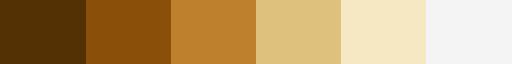

In [11]:
cmap = discrete_cmap(6,truncate_colormap(cmap=colormaps['BrBG'],minval =0,maxval=.5, n=100))
cmap

/tmp/ipykernel_64714/1287651238.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('BrBG', c_bins) #We can add discrete levels by specifying a <cmap>,<#of levs>)


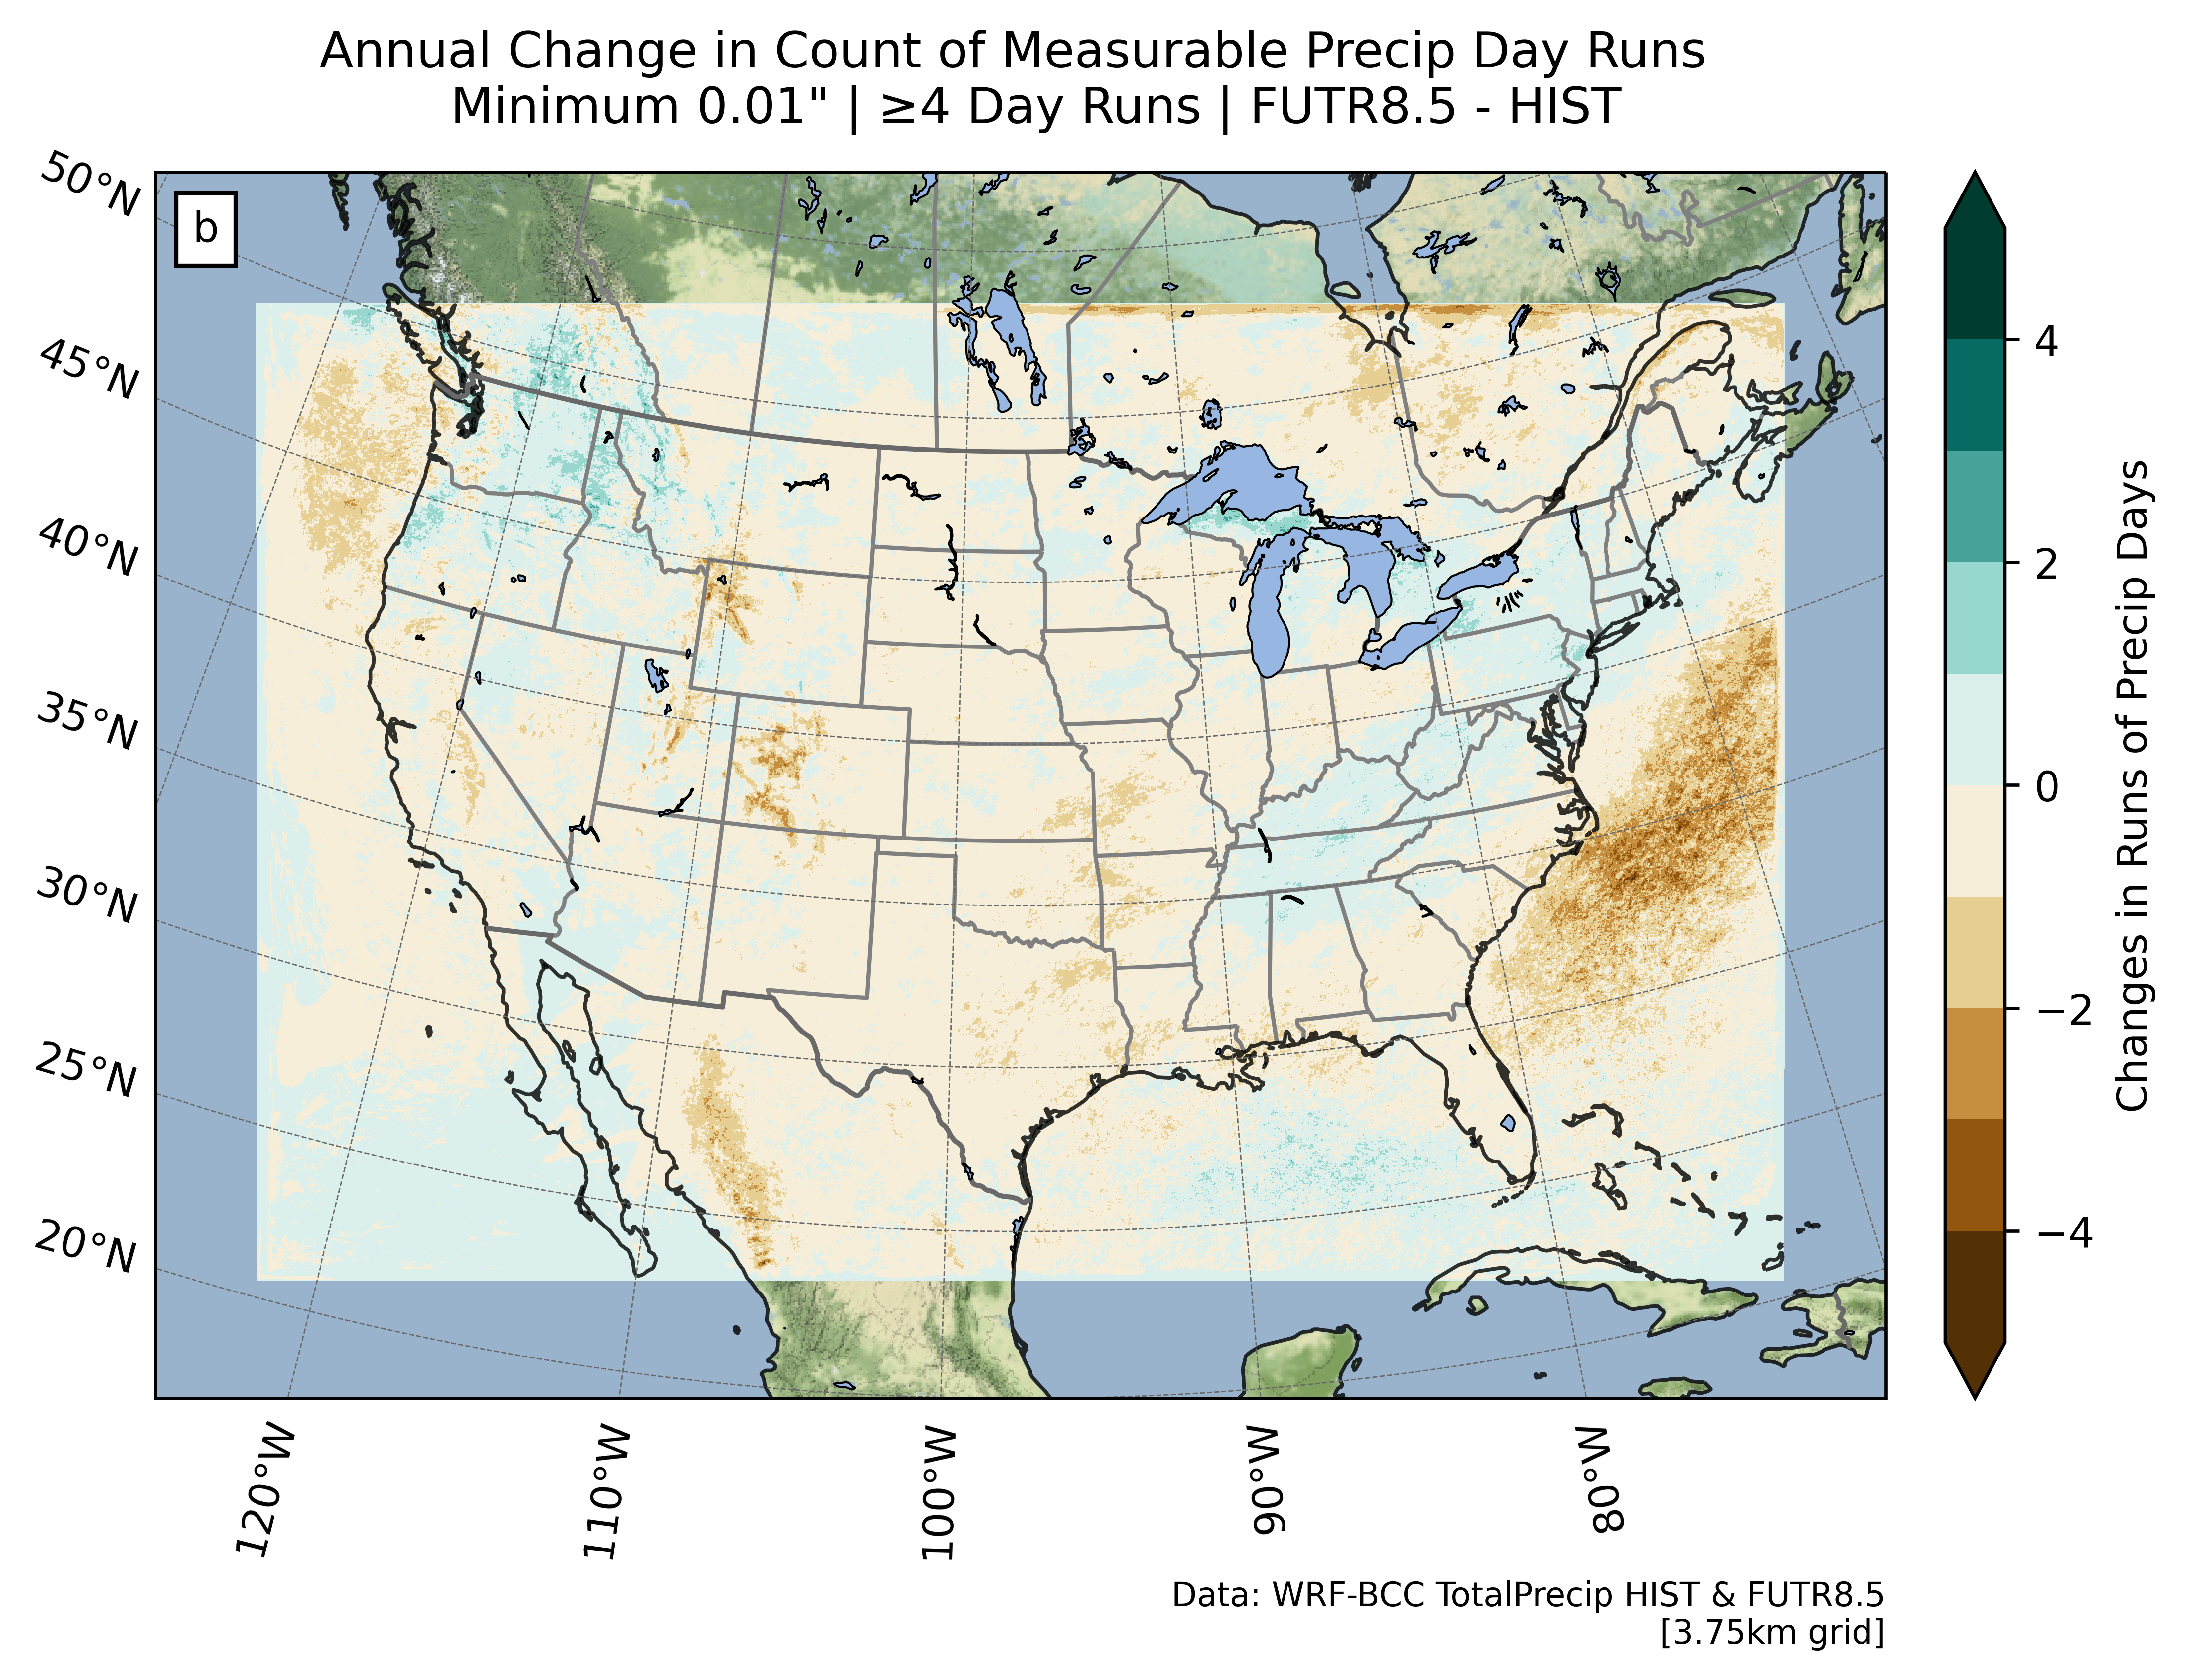

In [12]:
#create plot on a better map, takes a few seconds to plot, be patient, update labels manually
gs  = gridspec.GridSpec(2,3, width_ratios=[5, 5, 10], 
                       height_ratios=[5,5],
                       top = 0.75,
                       bottom = 0.1,
                       wspace = 0.5,
                       hspace = 0.5)

fig = plt.figure(figsize=(20, 10), frameon=True, dpi=600.0)

#Full extent: 
negXLim, posXLim, negYLim, posYLim= -125., -70., 20., 55.
#Clipped Illinois?:
#negXLim, posXLim, negYLim, posYLim= -92.5, -82.5, 45., 55.
#Clipped midwest-ish:
#negXLim, posXLim, negYLim, posYLim= -100., -80., 35., 50.


extent = [negXLim, posXLim, negYLim, posYLim]
c_bins = 10

#cmap = colormaps['BrBG']
# deprecated --- 
cmap = cm.get_cmap('BrBG', c_bins) #We can add discrete levels by specifying a <cmap>,<#of levs>)
#cmap = cm.get_cmap('YlOrBr_r', c_bins) #We can add discrete levels by specifying a <cmap>,<#of levs>)

vmin = -5 #0.
vmax = 5 #20.

p = ccrs.LambertConformal(central_longitude=-97.5, central_latitude=38.5, standard_parallels=(38.5, 38.5))
#p = ccrs.LambertConformal(central_longitude=-90.0, central_latitude=38.5, standard_parallels=(38.5, 38.5))
ax0 = fig.add_subplot(gs[:,2], projection=p)
ax0.set_extent(extent, crs=ccrs.PlateCarree())
#ax0.stock_img()  # oceans/land basemap
# Create a Stamen terrain background instance.
stamen_terrain = cimgt.Stamen('terrain-background')
ax0.add_image(stamen_terrain, 6, zorder=1)
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')
ax0.add_feature(states_provinces, edgecolor='gray', lw=1., zorder=2)
ax0.add_feature(cfeature.OCEAN, zorder=0)
ax0.add_feature(cfeature.COASTLINE, edgecolor='k', lw=.9, alpha=0.8, zorder=2)
ax0.add_feature(cfeature.BORDERS, edgecolor='dimgray', lw=1.2, zorder=2)
#ax0.add_feature(cfeature.RIVERS, lw=.5, alpha=.85, zorder=2)
ax0.add_feature(cfeature.LAKES, edgecolor='k', lw=.5, zorder=2)

# *must* call canvas.draw in order to get the axis boundary used to add ticks:
fig.canvas.draw()
xticks = list(np.arange(-120, -60, 10))
yticks = list(np.arange(20, 60, 10))
#ax0.gridlines(xlocs=xticks, ylocs=yticks, lw=.5, color='dimgray', linestyle='--', zorder=2)


# plot the actual data

mesh = ax0.pcolormesh(precip_runs_window_evt_dep.AFWA_TOTPRECIP.lon,
                      precip_runs_window_evt_dep.AFWA_TOTPRECIP.lat,
                      precip_runs_window_evt_dep.AFWA_TOTPRECIP,
                      cmap=cmap,
                      transform=ccrs.PlateCarree(),
                      shading='auto',
                      vmin=vmin, 
                      vmax=vmax,
                      #alpha=.5,    # be careful with alpha, as c_bar is on a white background
                      #add_labels=True,
                      #norm=colors.LogNorm(vmin=1, vmax=20, clip=True),
                      zorder=1)

ax0.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
ax0.yaxis.set_major_formatter(LATITUDE_FORMATTER)
#lcc_pf.lambert_xticks(ax0, xticks)
#lcc_pf.lambert_yticks(ax0, yticks)
gl = ax0.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, x_inline=False, y_inline=False, linewidth=0.33, color='dimgray', linestyle='--')
gl.right_labels = gl.top_labels = False
gl.ylocator = ticker.AutoLocator()#FixedLocator([25,30,35,40, 45, 50])
gl.xlocator = ticker.AutoLocator()#FixedLocator([-100, -95, -90, -85, -80, -75, -70])


#ax0 titles, text, labels, etc
ax0.title.set_text(f'Annual Change in Count of Measurable Precip Day Runs \n  Minimum 0.01" | ≥4 Day Runs | FUTR8.5 - HIST' )
ax0.set_xlabel("")  # X & Y shouldn't need lables in this context, just lat and lon
ax0.set_ylabel("")
anchored_text = AnchoredText("b", loc=2)
ax0.add_artist(anchored_text)
ax0.text(1.,-0.2, "Data: WRF-BCC TotalPrecip HIST & FUTR8.5\n[3.75km grid]",
         size=8, ha="right", 
         transform=ax0.transAxes)

#add our colorbar for all axes
# rect that defines cbar if we pass cax=cax parameter to fig.colorbar
# we cannot use the divide trick for 'mpl simple colorbar' to subvdivide a geo axis
ax0_lims=ax0.get_position()       #https://matplotlib.org/3.1.1/api/transformations.html#matplotlib.transforms.BboxBase
cax = fig.add_axes((0.91, ax0_lims.corners()[0,1], 0.01, ax0_lims.height))    #set lims to (bottom corner x, bottom corner y(from ax0 plot), width, height(ax0 height))
#cmap.set_over('#98d7cd')
#cmap.set_under("wheat")
color_bar = fig.colorbar(mesh, cax=cax, extend='both')
color_bar.set_label(r'Changes in Runs of Precip Days', labelpad=5, fontsize=10) #neg vals move labelpad left (pixels)
#color_bar.ax.set_yticklabels(['-5', '-4', '-3', '-2', '-1', '0', '1', '2', '3', '4', '5'])  # vertically oriented colorbar
#color_bar.ax.locator_params(nbins=c_bins) # sets number of ticks equal to number of color bins
#color_bar.update_ticks()

#### Check for runs of dry days

In [13]:
# we invert the precip data with the "~" operator after the runs to remove the overhead of inverting all the data

# minimum run length of 2 ("consecutive days") defined here: https://doi.org/10.1175/JAMC-D-14-0319.1
dry_runs_window_evt0 = ~ xc.indices.run_length.windowed_run_events(da=da0,#.chunk(dict(time=-1)).unify_chunks(),
                                                                 window=2,
                                                                 dim="time",
                                                                )#.to_dataset(name='AFWA_TOTPRECIP_FIRST_RUN')
#dry_runs_constr_cnt = dry_runs_constr_cnt.where(precip_runs_constr_cnt != 0)

dry_runs_window_evt1 = ~ xc.indices.run_length.windowed_run_events(da=da1,#.chunk(dict(time=-1)).unify_chunks(),
                                                                 window=2,
                                                                 dim="time",
                                                                )#.to_dataset(name='AFWA_TOTPRECIP_FIRST_RUN')
#dry_runs_constr_cnt = dry_runs_constr_cnt.where(precip_runs_constr_cnt != 0)


In [14]:
dry_runs_window_evt_dep = dry_runs_window_evt1 - dry_runs_window_evt0
dry_runs_window_evt_dep = dry_runs_window_evt_dep/15

/tmp/ipykernel_64714/4230939315.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  base = plt.cm.get_cmap(base_cmap)


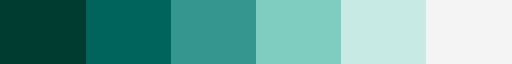

In [15]:
cmap = discrete_cmap(6,truncate_colormap(cmap=colormaps['BrBG_r'],minval =0,maxval=.5, n=100))
cmap

/tmp/ipykernel_59465/3787648155.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('BrBG_r', c_bins) #We can add discrete levels by specifying a <cmap>,<#of levs>)


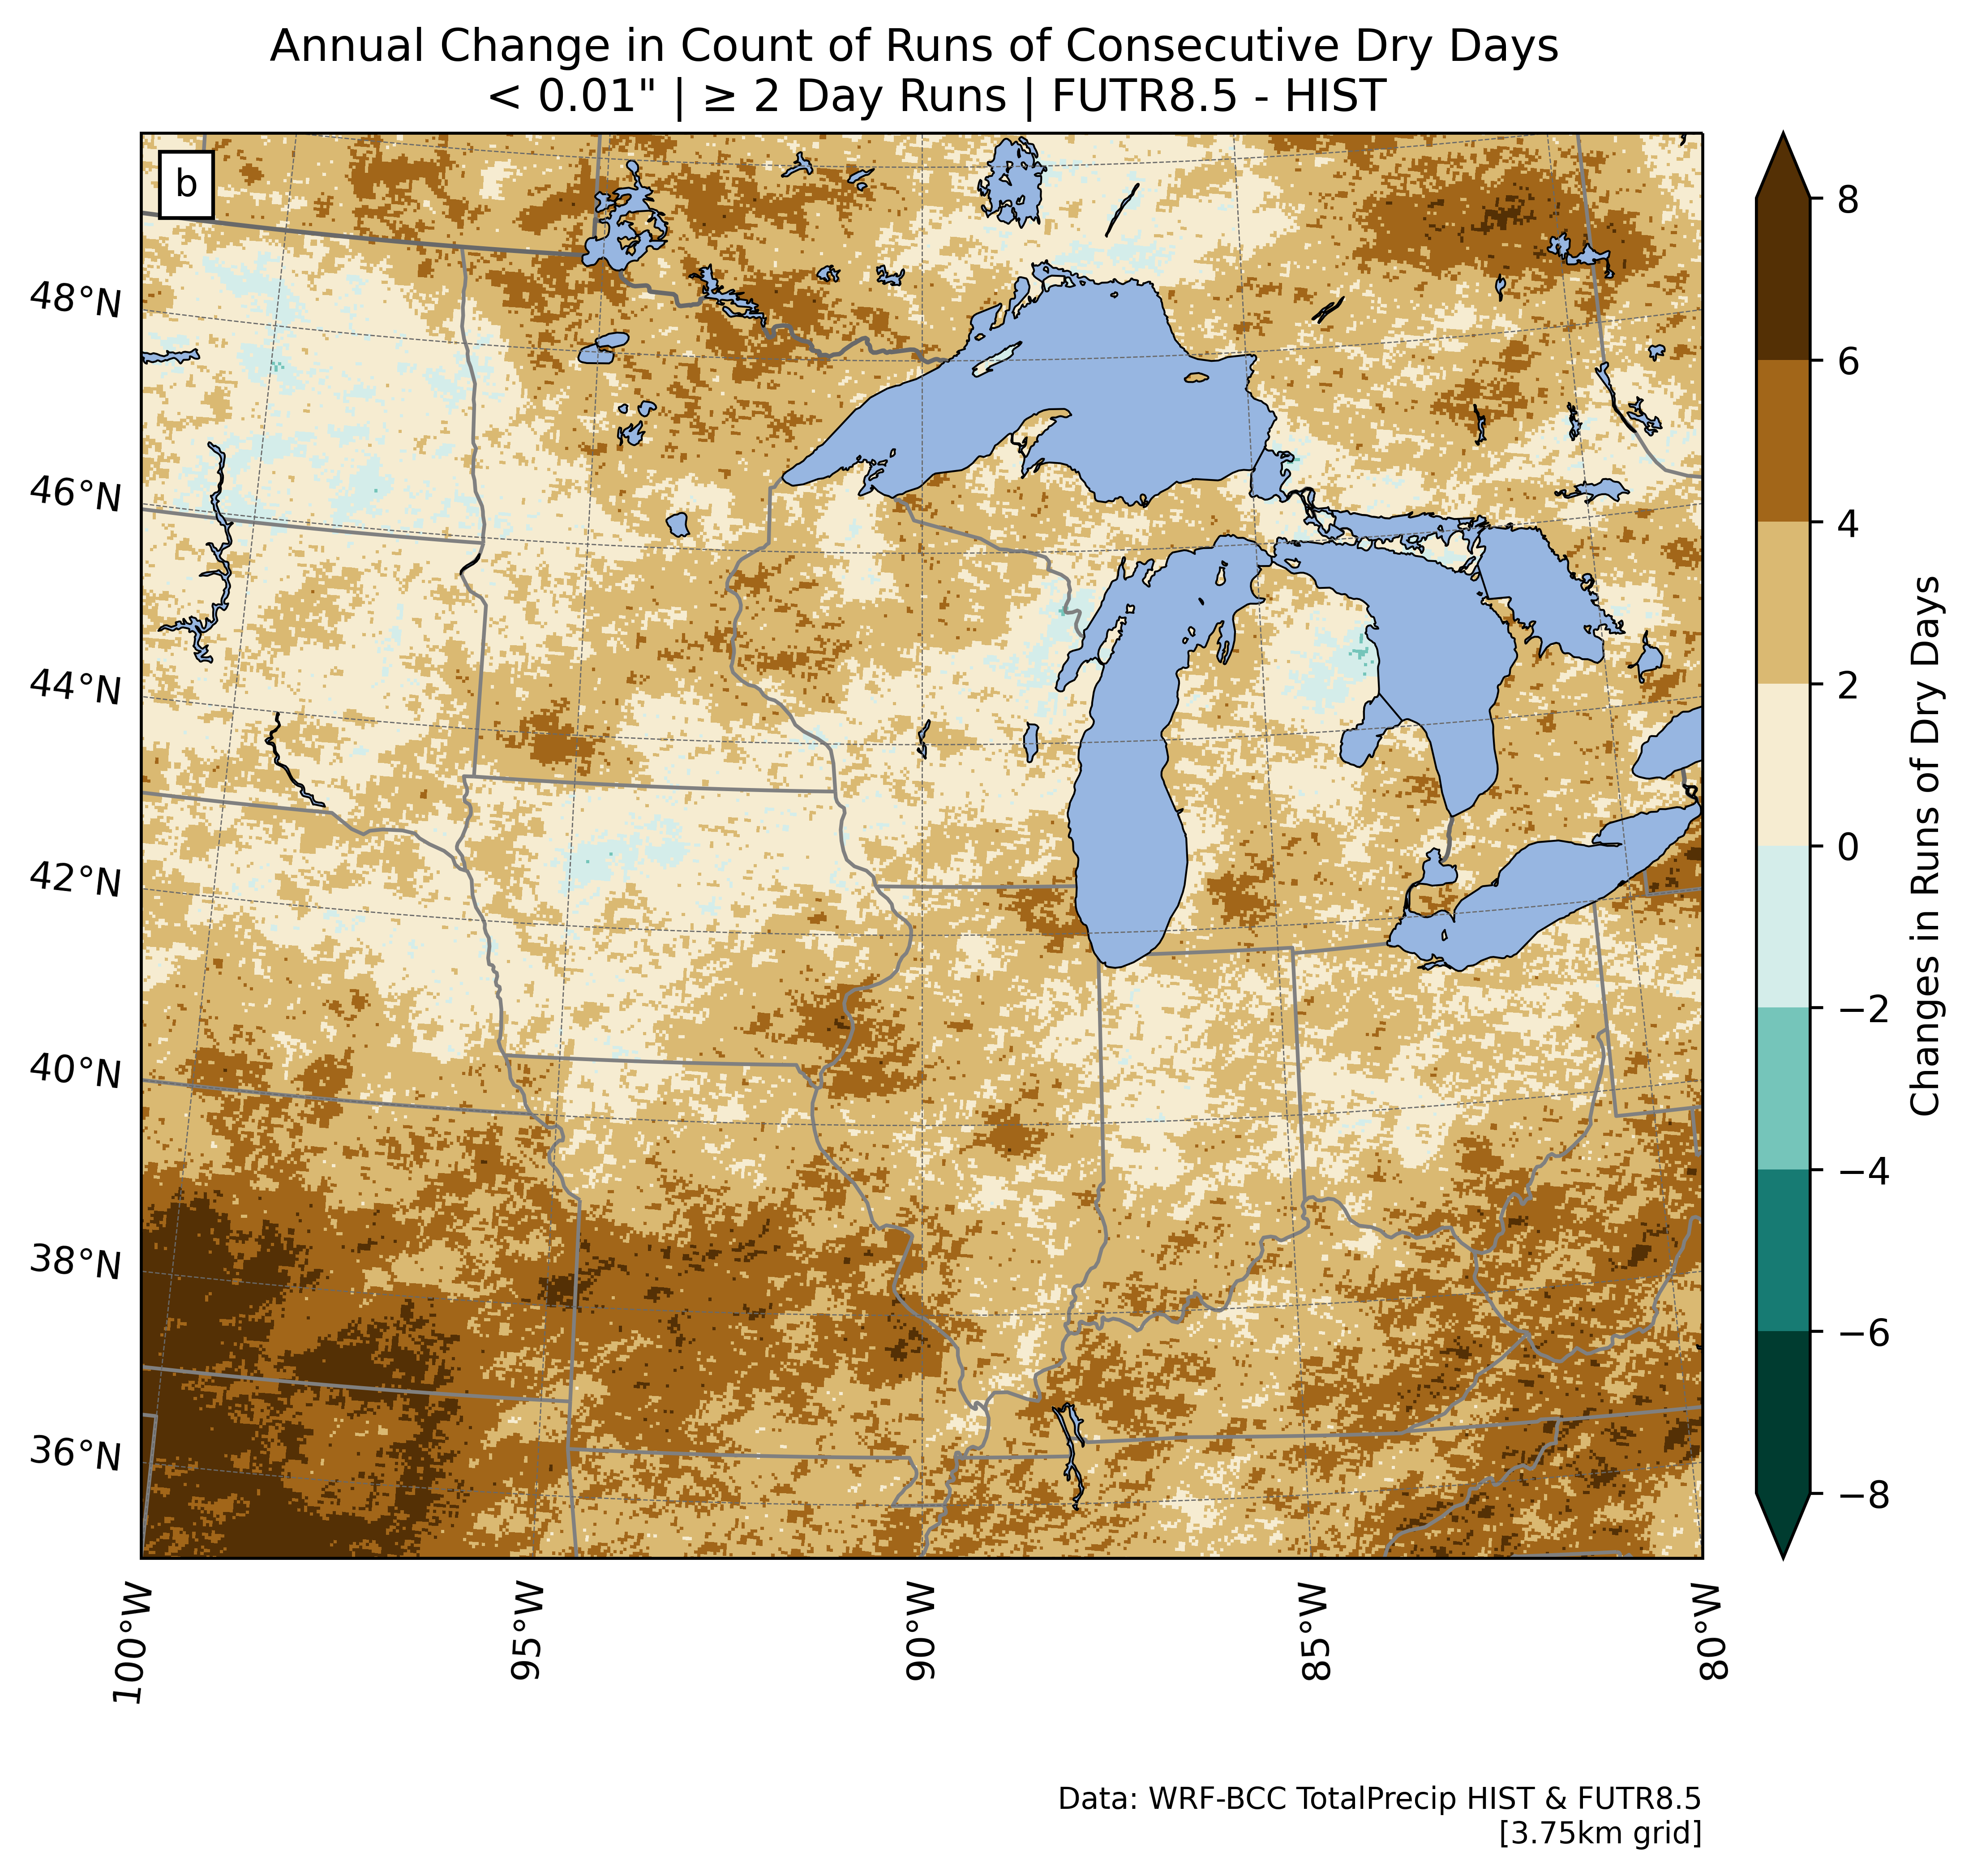

In [36]:
#create plot on a better map, takes a few seconds to plot, be patient, update labels manually
gs  = gridspec.GridSpec(2,3, width_ratios=[5, 5, 10], 
                       height_ratios=[5,5],
                       top = 0.75,
                       bottom = 0.1,
                       wspace = 0.5,
                       hspace = 0.5)

fig = plt.figure(figsize=(20, 10), frameon=True, dpi=600.0)

#Full extent: 
#negXLim, posXLim, negYLim, posYLim= -125., -70., 20., 55.
#Clipped Illinois?:
#negXLim, posXLim, negYLim, posYLim= -92.5, -82.5, 45., 55.
#Clipped midwest-ish:
negXLim, posXLim, negYLim, posYLim= -100., -80., 35., 50.


extent = [negXLim, posXLim, negYLim, posYLim]
c_bins = 8

#cmap = colormaps['BrBG']
# deprecated --- 
cmap = cm.get_cmap('BrBG_r', c_bins) #We can add discrete levels by specifying a <cmap>,<#of levs>)
#cmap = cm.get_cmap('YlOrBr_r', c_bins) #We can add discrete levels by specifying a <cmap>,<#of levs>)

vmin = -8 #0.
vmax = 8 #20.

#p = ccrs.LambertConformal(central_longitude=-97.5, central_latitude=38.5, standard_parallels=(38.5, 38.5))
p = ccrs.LambertConformal(central_longitude=-90.0, central_latitude=38.5, standard_parallels=(38.5, 38.5))
ax0 = fig.add_subplot(gs[:,2], projection=p)
ax0.set_extent(extent, crs=ccrs.PlateCarree())
#ax0.stock_img()  # oceans/land basemap
# Create a Stamen terrain background instance.
stamen_terrain = cimgt.Stamen('terrain-background')
ax0.add_image(stamen_terrain, 6, zorder=1)
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')
ax0.add_feature(states_provinces, edgecolor='gray', lw=1., zorder=2)
ax0.add_feature(cfeature.OCEAN, zorder=0)
ax0.add_feature(cfeature.COASTLINE, edgecolor='k', lw=.9, alpha=0.8, zorder=2)
ax0.add_feature(cfeature.BORDERS, edgecolor='dimgray', lw=1.2, zorder=2)
#ax0.add_feature(cfeature.RIVERS, lw=.5, alpha=.85, zorder=2)
ax0.add_feature(cfeature.LAKES, edgecolor='k', lw=.5, zorder=2)

# *must* call canvas.draw in order to get the axis boundary used to add ticks:
fig.canvas.draw()
xticks = list(np.arange(-120, -60, 10))
yticks = list(np.arange(20, 60, 10))
#ax0.gridlines(xlocs=xticks, ylocs=yticks, lw=.5, color='dimgray', linestyle='--', zorder=2)


# plot the actual data

mesh = ax0.pcolormesh(dry_runs_window_evt_dep.AFWA_TOTPRECIP.lon,
                      dry_runs_window_evt_dep.AFWA_TOTPRECIP.lat,
                      dry_runs_window_evt_dep.AFWA_TOTPRECIP,
                      cmap=cmap,
                      transform=ccrs.PlateCarree(),
                      shading='auto',
                      vmin=vmin, 
                      vmax=vmax,
                      #alpha=.5,    # be careful with alpha, as c_bar is on a white background
                      #add_labels=True,
                      #norm=colors.LogNorm(vmin=1, vmax=20, clip=True),
                      zorder=1)

ax0.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
ax0.yaxis.set_major_formatter(LATITUDE_FORMATTER)
#lcc_pf.lambert_xticks(ax0, xticks)
#lcc_pf.lambert_yticks(ax0, yticks)
gl = ax0.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, x_inline=False, y_inline=False, linewidth=0.33, color='dimgray', linestyle='--')
gl.right_labels = gl.top_labels = False
gl.ylocator = ticker.AutoLocator()#FixedLocator([25,30,35,40, 45, 50])
gl.xlocator = ticker.AutoLocator()#FixedLocator([-100, -95, -90, -85, -80, -75, -70])


#ax0 titles, text, labels, etc
ax0.title.set_text(f'Annual Change in Count of Runs of Consecutive Dry Days \n  < 0.01" | ≥ 2 Day Runs | FUTR8.5 - HIST' )
ax0.set_xlabel("")  # X & Y shouldn't need lables in this context, just lat and lon
ax0.set_ylabel("")
anchored_text = AnchoredText("b", loc=2)
ax0.add_artist(anchored_text)
ax0.text(1.,-0.2, "Data: WRF-BCC TotalPrecip HIST & FUTR8.5\n[3.75km grid]",
         size=8, ha="right", 
         transform=ax0.transAxes)

#add our colorbar for all axes
# rect that defines cbar if we pass cax=cax parameter to fig.colorbar
# we cannot use the divide trick for 'mpl simple colorbar' to subvdivide a geo axis
ax0_lims=ax0.get_position()       #https://matplotlib.org/3.1.1/api/transformations.html#matplotlib.transforms.BboxBase
cax = fig.add_axes((0.91, ax0_lims.corners()[0,1], 0.01, ax0_lims.height))    #set lims to (bottom corner x, bottom corner y(from ax0 plot), width, height(ax0 height))
#cmap.set_over('#98d7cd')
#cmap.set_under("wheat")
color_bar = fig.colorbar(mesh, cax=cax, extend='both')
color_bar.set_label(r'Changes in Runs of Dry Days', labelpad=5, fontsize=10) #neg vals move labelpad left (pixels)
#color_bar.ax.set_yticklabels(['-5', '-4', '-3', '-2', '-1', '0', '1', '2', '3', '4', '5'])  # vertically oriented colorbar
#color_bar.ax.locator_params(nbins=c_bins) # sets number of ticks equal to number of color bins
#color_bar.update_ticks()

In [11]:
da1.AFWA_TOTPRECIP.unify_chunks()

<xarray.DataArray 'AFWA_TOTPRECIP' (Time: 5477, south_north: 899,
                                    west_east: 1399)>
dask.array<concatenate, shape=(5477, 899, 1399), dtype=bool, chunksize=(242, 596, 928), chunktype=numpy.ndarray>
Coordinates:
    lon      (south_north, west_east) float32 dask.array<chunksize=(596, 928), meta=np.ndarray>
    lat      (south_north, west_east) float32 dask.array<chunksize=(596, 928), meta=np.ndarray>
  * Time     (Time) datetime64[ns] 2085-10-01T12:00:00 ... 2100-09-29T12:00:00
Dimensions without coordinates: south_north, west_east

In [9]:
#need to use chunk to drop this into one chunk. this will have dask perfomeance penelties. 
'''precip_runs_constr_fr = xc.indices.run_length.first_run_ufunc(x=is_target_precip.chunk(dict(time=-1)),
                                                              window=4,
                                                              dim="time",
                                                              )#.to_dataset(name='AFWA_TOTPRECIP_FIRST_RUN')'''

precip_runs_constr_fr0 = xc.indices.run_length.first_run(da=da0.AFWA_TOTPRECIP.unify_chunks(),
                                                         window=7,
                                                         dim="time",
                                                         coord=True
                                                        ).to_dataset(name='AFWA_TOTPRECIP_FIRST_RUN')

precip_runs_constr_fr1 = xc.indices.run_length.first_run(da=da1.AFWA_TOTPRECIP.unify_chunks(),
                                                         window=7,
                                                         dim="time",
                                                         coord=True
                                                        ).to_dataset(name='AFWA_TOTPRECIP_FIRST_RUN')



ValueError: dimensions ('south_north', 'west_east') must have the same length as the number of data dimensions, ndim=0

In [ ]:
#NOTE: NOT accounting for leap years!
#This is phenomanally inefficent, vectorize is a convience function, we need a better way to apply a method to each element in a data array
def date_to_DoY(d):
    if isinstance(d, int):
        #print(type(d), pd.Timestamp(np.datetime64('1970', 'Y') + np.timedelta64(d,"ns")).date().timetuple().tm_yday)
        try:
            doy = pd.Timestamp(np.datetime64('1970', 'Y') + np.timedelta64(d,"ns")).date().timetuple().tm_yday
            #print(doy)
            return doy
        except AttributeError:
            print("encountered issue parsing int")
            return np.nan
    return np.nan
    
d_t_d = np.vectorize(date_to_DoY)

precip_runs_constr_fr_data0 = d_t_d(dry_runs_window_evt0.values).astype(int)    # this *should* be int already, just doubling down.
precip_runs_constr_fr_data1 = d_t_d(dry_runs_window_evt1.values).astype(int)    # this *should* be int already, just doubling down.


precip_runs_constr_fr_data0 = precip_runs_constr_fr_data0.where(precip_runs_constr_fr_data0 >= 0, precip_runs_constr_fr_data0, np.nan)
precip_runs_constr_fr_data1 = precip_runs_constr_fr_data1.where(precip_runs_constr_fr_data1 >= 0, precip_runs_constr_fr_data1, np.nan)

precip_runs_constr_fr0.assign(AFWA_TOTPRECIP_FIRST_RUN = (precip_runs_constr_fr0.coords, d_t_d(precip_runs_constr_fr0.AFWA_TOTPRECIP_FIRST_RUN.values).astype(int)))
precip_runs_constr_fr1.assign(AFWA_TOTPRECIP_FIRST_RUN = (precip_runs_constr_fr1.coords, d_t_d(precip_runs_constr_fr1.AFWA_TOTPRECIP_FIRST_RUN.values).astype(int)))

#precip_runs_constr_fr.AFAW_TOTPRECIP_FIRST_RUN
precip_runs_constr_fr0 = precip_runs_constr_fr0.date.timetuple()#.tm_yday
precip_runs_constr_fr1 = precip_runs_constr_fr1.date.timetuple()#.tm_yday

In [17]:
precip_runs_constr_fr_data0 = precip_runs_constr_fr_data0.astype(float)
precip_runs_constr_fr_data0[precip_runs_constr_fr_data0 <= 0] = np.nan # or use np.nan

#precip_runs_constr_fr_data = precip_runs_constr_fr_data.where(precip_runs_constr_fr_data >= 0, precip_runs_constr_fr_data, np.nan)
#precip_runs_constr_fr_data.where(precip_runs_constr_fr_data != 0)

precip_runs_constr_fr_data1 = precip_runs_constr_fr_data1.astype(float)
precip_runs_constr_fr_data1[precip_runs_constr_fr_data1 <= 0] = np.nan # or use np.nan

In [18]:
precip_runs_constr_fr_data0.min()
#precip_runs_constr_fr.AFWA_TOTPRECIP_FIRST_RUN.values

nan

In [19]:
precip_runs_constr_fr_data1.min()
#precip_runs_constr_fr.AFWA_TOTPRECIP_FIRST_RUN.values

nan

In [21]:
#plot as a mesh in its own fig for now until it can be integrated back into xarray 

#plt.imshow(precip_runs_constr_fr_data)#, extent=[min_lon, max_lon, min_lat, min_lon])
#plt.show()

#fig, (ax0, ax1) = plt.subplots(nrows=2)

x=precip_runs_constr_fr0.coords['lon']
y=precip_runs_constr_fr0.coords['lat']
z=precip_runs_constr_fr_data0

#print(x.shape)
#print(y.shape)
#print(z.shape)

#mesh = ax0.pcolormesh(x=precip_runs_constr_fr.coords['lon'],
#                      y=precip_runs_constr_fr.coords['lat'],
#                      z=precip_runs_constr_fr_data,
#                      shading='auto',
#                      xlim=[min_lon - .5, max_lon + .5],
#                      ylim=[min_lat - .5, max_lat + .5],
#                      #norm=colors.LogNorm(vmin=0.000001, clip=True),
#                     )

#wont work cause of calling this on a np array. need to convert to a data array
#mesh = precip_runs_constr_fr.AFWA_TOTPRECIP_FIRST_RUN.pcolormesh(x=precip_runs_constr_fr.coords['lon'],
#                                                                      y=precip_runs_constr_fr.coords['lon'],
#                                             xlim=[min_lon - .5, max_lon + .5],
#                                             ylim=[min_lat - .5, max_lat + .5],
#                                             #norm=colors.LogNorm(vmin=0.000001, clip=True),
#                                            )


#create plot
gs  = gridspec.GridSpec(2,3, width_ratios=[5, 5, 10], 
                       height_ratios=[5,5],
                       top = 0.75,
                       bottom = 0.1,
                       wspace = 0.5,
                       hspace = 0.5)

fig = plt.figure(figsize=(20, 10), frameon=True, dpi=600.0)

#Full extent: 
negXLim, posXLim, negYLim, posYLim= -125., -70., 20., 55.
#Clipped:
#negXLim, posXLim, negYLim, posYLim= -92.5, -82.5, 45., 55.

extent = [negXLim, posXLim, negYLim, posYLim]
#c_bins = 25
cmap = cm.get_cmap('twilight_shifted') #We can add discrete levels by specifying a <cmap>,<#of levs>)

p = ccrs.LambertConformal(central_longitude=262.5, central_latitude=38.5, standard_parallels=(38.5, 38.5))
ax0 = fig.add_subplot(gs[:,2], projection=p)
ax0.set_extent(extent, crs=ccrs.PlateCarree())
#ax0.stock_img()  # oceans/land basemap
# Create a Stamen terrain background instance.
stamen_terrain = cimgt.Stamen('terrain-background')
ax0.add_image(stamen_terrain, 6, zorder=1)
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')
ax0.add_feature(states_provinces, edgecolor='gray', lw=1., zorder=2)
ax0.add_feature(cfeature.OCEAN, zorder=0)
ax0.add_feature(cfeature.COASTLINE, edgecolor='k', lw=.9, alpha=0.8, zorder=2)
ax0.add_feature(cfeature.BORDERS, edgecolor='dimgray', lw=1.2, zorder=2)
ax0.add_feature(cfeature.RIVERS, lw=.5, alpha=.85, zorder=2)
ax0.add_feature(cfeature.LAKES, edgecolor='k', lw=.5, zorder=2)

# *must* call canvas.draw in order to get the axis boundary used to add ticks:
fig.canvas.draw()
xticks = list(np.arange(-120, -60, 10))
yticks = list(np.arange(20, 60, 10))
ax0.gridlines(xlocs=xticks, ylocs=yticks, lw=.5, color='dimgray', linestyle='--', zorder=2)


# plot the actual data
#precip_at_time
'''mesh = precip_runs_constr_x.plot.pcolormesh(x='lon', y='lat',
                                            transform=ccrs.PlateCarree(),
                                            ax=0,
                                            cmap=cmap,
                                            shading='auto',
                                            zorder=3
                                             #xlim=[min_lon - .5, max_lon + .5],
                                             #ylim=[min_lat - .5, max_lat + .5],
                                             #norm=colors.LogNorm(vmin=0.000001, clip=True),
                                            )
'''
mesh = ax0.pcolormesh(x, y, z,
                                      cmap=cmap,
                                      transform=ccrs.PlateCarree(),
                                      shading='auto',
                                      vmin=1., 
                                      vmax=365.,
                                      #norm=colors.LogNorm(vmin=0.1, vmax=100, clip=True),
                                      #alpha=.5,    # be careful with alpha, as c_bar is on a white background
                                      #add_labels=True,
                                      zorder=2)

ax0.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
ax0.yaxis.set_major_formatter(LATITUDE_FORMATTER)
lcc_pf.lambert_xticks(ax0, xticks)
lcc_pf.lambert_yticks(ax0, yticks)

#ax0 titles, text, labels, etc
#ax0.title.set_text("Valid starting: " + t_label)
ax0.set_xlabel("")  # X & Y shouldn't need lables in this context, just lat and lon
ax0.set_ylabel("")
anchored_text = AnchoredText("b", loc=2)
ax0.add_artist(anchored_text)
ax0.text(1.,-0.15, "Data: WRF-BCC TotalPrecip DOY of first spell \n[** km x km]",
         size=8, ha="right", 
         transform=ax0.transAxes)

# if you wanted to subset for visulization without adjusting axes extent, could be a non rect. patch as well
#patch = patches.Rectangle((negXLim, negYLim), 
#                          posXLim-negXLim, 
#                          posYLim-negYLim,  
#                          transform = ax0.transData)     
#ax0.pcolormesh(lons[400:1200,1400:1600], lats[400:1200,1400:1600], data[400:1200,1400:1600],
#               cmap = plt.get_cmap('jet'), vmin=0, vmax=50)#,
#              #clip_path=patch)

#add our colorbar for all axes
# rect that defines cbar if we pass cax=cax parameter to fig.colorbar
# we cannot use the divide trick for 'mpl simple colorbar' to subvdivide a geo axis
ax0_lims=ax0.get_position()       #https://matplotlib.org/3.1.1/api/transformations.html#matplotlib.transforms.BboxBase
cax = fig.add_axes((0.91, ax0_lims.corners()[0,1], 0.01, ax0_lims.height))    #set lims to (bottom corner x, bottom corner y(from ax0 plot), width, height(ax0 height))
#cmap.set_over("red")
color_bar = fig.colorbar(mesh, cax=cax)
color_bar.set_label('Day of Year of first spell > 4 days', labelpad=5, fontsize=10) #neg vals move labelpad left (pixels)
#color_bar.ax.locator_params(nbins=c_bins)

NameError: name 'precip_runs_constr_fr0' is not defined

In [13]:
# Define your custom function using xclim.indices.run_length.first_run_after_date
def custom_function(data):
    result = xclim.indices.run_length.first_run_after_date(data, date='04-01')
    return result

# Resample data by year starting from October 1st and apply the custom function
grouped_data = ds0.resample(time='AS-OCT').apply(custom_function)

# Create a new dataset to store the results
results_ds = xr.Dataset()

# Iterate through each year's data and append to the results dataset
for year in grouped_data.time:
    year_data = grouped_data.sel(time=year)
    result = year_data['your_variable_name']  # Replace with the actual variable name
    results_ds = xr.concat([results_ds, result], dim='time')

NameError: name 'ds0' is not defined

In [12]:
precip_runs_constr_x

<xarray.DataArray 'AFWA_TOTPRECIP' (south_north: 899, west_east: 1399)>
dask.array<where, shape=(899, 1399), dtype=float64, chunksize=(596, 928), chunktype=numpy.ndarray>
Coordinates:
    lon      (south_north, west_east) float32 -121.8 -121.8 ... -61.38 -61.34
    lat      (south_north, west_east) float32 20.51 20.52 20.53 ... 48.91 48.89
Dimensions without coordinates: south_north, west_east

/anaconda3/envs/pyEAE/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/anaconda3/envs/pyEAE/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/anaconda3/envs/pyEAE/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/anaconda3/envs/pyEAE/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


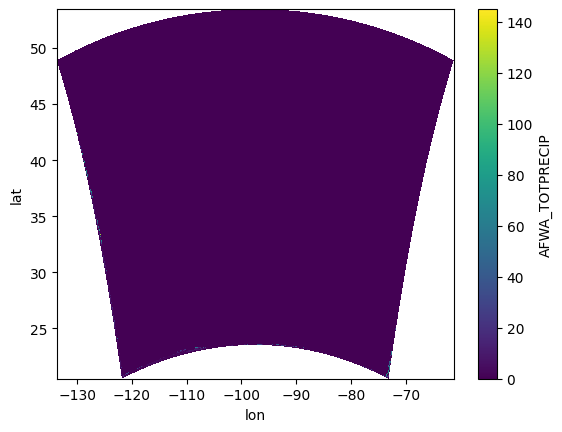

In [13]:
mesh = precip_runs_constr_x.plot.pcolormesh(x='lon', y='lat',
                                             #xlim=[min_lon - .5, max_lon + .5],
                                             #ylim=[min_lat - .5, max_lat + .5],
                                             #norm=colors.LogNorm(vmin=0.000001, clip=True),
                                            )